# Self supervised Shortcut analysis

In [1]:
s3_train_prediction="s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091718/train.json.json"
s3_test_prediction="s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091718/test.json.json"
s3_val_prediction="s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091718/val.json.json"





s3_largescale_high_quality_prediction = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920_negative_generalisation/highquality_sample.json"
s3_largescale_low_quality_prediction = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920_negative_generalisation/lowquality_sample.json"




x_column = "abstract"
prediction_y_column = "prediction"


label_names = ["False","True"]
all_labels = label_names

## Download prediction

In [2]:
import sys, os, pandas as pd, sklearn
pd.set_option('display.max_colwidth',None)


sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

In [3]:
local_temp= "temp"

In [4]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)
local_highquality_file = download_s3_file(s3_largescale_high_quality_prediction, local_prediction_dir)
local_lowquality_file = download_s3_file(s3_largescale_low_quality_prediction, local_prediction_dir)





## Utils

In [5]:
keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
    

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       )
    df["self_label"] =  df["self_label"].astype(str)
    
    return df
    

def load_file(file, labels_order = label_names):
    df = pd.read_json(file, orient="records").pipe(self_label)
    

    df["x"] = df[x_column]
    df["gold"] = df["self_label"].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df["self_label"]

    df["y"] = df[prediction_y_column].apply(lambda x: labels_order.index(str(x)))
    df["y_raw"] = df[prediction_y_column].astype(str)


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [6]:
import transformers

def hf_analyser():
    t = transformers.AutoTokenizer.from_pretrained("bert-base-cased")


    return lambda x: t.convert_ids_to_tokens(t([x], add_special_tokens=False)["input_ids"][0])[:512]
    

In [7]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES}, max_words_per_class=5000, classwise_vocab=True):
    
    max_tree_depth = 8
    min_df = min_df or 3
    
    nb_kwargs = {
        "min_df": min_df,
        "max_words_per_class":max_words_per_class, 
        "stop_words": stop_words, 
        "ngram_range": ngram_range, 
        "classwise_vocab": classwise_vocab,
        "analyzer" : hf_analyser()
    }
    
   
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier(None, None, **nb_kwargs),
    
    }
    
    result = {}
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
             "predictions_conf": p_conf
        }
    return result


def  predict_all_classifiers(df, models_dict):
   
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result




In [8]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred,  label_names = label_names):

    
  
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    

def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    
    for k, v in results_dict.items():

        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df    
    

In [9]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [10]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])




In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred, normalize=normalize)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [12]:
import math
from scipy.spatial import distance


def _build_list(l1,l2, use_common_only=True):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
           
    if use_common_only:
        intersection = set([w for w,_ in l2]).intersection(set([w for w,_ in l1]))
        word_index = {w:i for i,w in enumerate(intersection)}


    
    l1_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l1)):        
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l2)):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r

def js_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return distance.jensenshannon(p,q, 2.71828)

def kl_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return sum(p[i] * math.log(p[i]/q[i]) for i in range(len(p)))

In [13]:
import scipy

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(df, normalize=None):

    cm = confusion_matrix(df["self_label"],
                          df["prediction"], 
                          normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    


## Train GT Train predictions

In [15]:
df_train = load_file(local_train_prediction_file)


In [16]:
df_train.head()

,abstract,abstract_id,false,true,prediction,confidence,confidence_std,raw_confidence,self_label,x,gold,gold_raw,y,y_raw
0,"Cyclin E-cdk2 activation is associated with cell cycle arrest and inhibition of DNA replication induced by the thymidylate synthase inhibitor Tomudex. Tomudex (ZD1694) is a specific antifolate-based thymidylate synthase inhibitor active in a variety of solid tumor malignancies. Studies were carried out in vitro to evaluate downstream molecular alterations induced as a consequence of the potent and sustained inhibition of thymidylate synthase by Tomudex. Twenty-four hours following the initial 2-h treatment with Tomudex, human A253 head and neck squamous carcinoma cells, not expressing p53 and p21(WAF1), were accumulated with DNA content characteristic of early S phase of the cell cycle with a concomitant reduction of cells in G1 and G2/M phases. The changes in cyclin and cdk protein expression and their kinase activities were examined in control and drug-treated A253 cells. Tomudex treatment resulted in the decrease in p27(kip1) expression, with an increase in cyclin E and cdk2 protein expression and kinase activities 24 h after a 2-h exposure. Although cyclin A protein expression was markedly increased, cyclin A kinase activity was only slightly increased. Cyclin D1, cyclin B, cdk4, and cdc2 protein expression and kinase activities remain constant. Lack of activation of cyclin A- and B-cdc2 was associated with a reduced proportion of cells in G2/M phases. Increased cyclin E-cdk2 protein expression was accompanied by the inhibition of DNA synthesis, with a decrease in E2F-1 expression. These results propose that cyclin E-cdk2 kinase can negatively regulate DNA replication. The studies with dThyd rescue from cyclin E-cdk2 protein overexpression and growth inhibition by Tomudex indicate that increased cyclin E-cdk2 protein expression is associated with effective inhibition of thymidylate synthase and resultant dNTP pool imbalance. Provision of dThyd more than 24 h after exposure to Tomudex allowed cells to replicate DNA for a single cycle back to G1, but did not prevent the profound growth-inhibitory effect manifested in the following 5 days. Tomudex treatment resulted in a time-dependent induction of the megabase DNA fragments, followed by secondary 50- to 300-kb DNA fragmentation. The 50- to 300-kb DNA fragmentation may be derived from the inhibition of DNA synthesis associated with cyclin E-cdk2 activation. These results suggest that the megabase DNA fragmentation is induced as a consequence of inhibition of thymidylate synthase by Tomudex and kilobase DNA fragmentation may correlate with the reduction of p27(kip1) expression and the increase in cyclin E and cdk2 kinase activities. Activation of cyclin E and cdk2 kinases allows cells to transit from G1 to S phase accompanied by the inhibition of DNA synthesis. The changes in cell cycle regulatory proteins associated with growth inhibition and DNA damage by Tomudex are not p53 dependent.",10047461,0.997039,0.002961,False,0.997039,NaN,[0.9970393776893611],False,"Cyclin E-cdk2 activation is associated with cell cycle arrest and inhibition of DNA replication induced by the thymidylate synthase inhibitor Tomudex. Tomudex (ZD1694) is a specific antifolate-based thymidylate synthase inhibitor active in a variety of solid tumor malignancies. Studies were carried out in vitro to evaluate downstream molecular alterations induced as a consequence of the potent and sustained inhibition of thymidylate synthase by Tomudex. Twenty-four hours following the initial 2-h treatment with Tomudex, human A253 head and neck squamous carcinoma cells, not expressing p53 and p21(WAF1), were accumulated with DNA content characteristic of early S phase of the cell cycle with a concomitant reduction of cells in G1 and G2/M phases. The changes in cyclin and cdk protein expression and their kinase activities were examined in control and drug-treated A253 cells. Tomudex treatment resulte

In [17]:
train_result = train_and_predict_all_classifiers(df_train, min_df=1)



print_report_all_classifiers(df_train["gold"],train_result)

/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  6087


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      99.5 &   94.3 &     96.8 &     628 \\
Naive Bayes &         True &      79.1 &   97.8 &     87.5 &     139 \\
Naive Bayes &     accuracy &      94.9 &   94.9 &     94.9 &       0 \\
Naive Bayes &    macro avg &      89.3 &   96.1 &     92.1 &     767 \\
Naive Bayes & weighted avg &      95.8 &   94.9 &     95.1 &     767 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.994958,0.942675,0.968111,628.000000
True,Naive Bayes,True,0.790698,0.978417,0.874598,139.000000
accuracy,Naive Bayes,accuracy,0.949153,0.949153,0.949153,0.949153
macro avg,Naive Bayes,macro avg,0.892828,0.960546,0.921355,767.000000
weighted avg,Naive Bayes,weighted avg,0.957941,0.949153,0.951164,767.000000


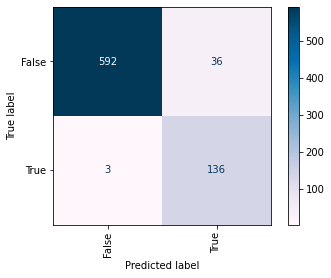

In [18]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"])

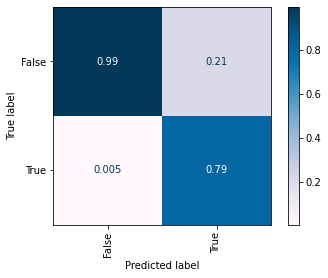

In [19]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"], normalize='pred')

In [20]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)[:50]

[('-', -3.589895776113094),
 ('.', -3.7232686273183386),
 ('of', -3.7753298298617484),
 (',', -3.7942110381075),
 ('the', -3.8274320861842765),
 ('and', -3.9734061055742895),
 ('in', -4.055690738165256),
 (')', -4.474507179448286),
 ('(', -4.475852169563618),
 ('a', -4.686290768972556),
 ('##s', -4.800550119772512),
 ('to', -4.811786193039438),
 ('##2', -5.296588043384124),
 ('by', -5.296588043384124),
 ('that', -5.318227218487605),
 ('is', -5.389454727775973),
 ('p', -5.427065998521756),
 ('##1', -5.437573976120171),
 ('with', -5.473420107893307),
 ('c', -5.581216678349015),
 ('1', -5.6312270989236755),
 ('C', -5.702053151492288),
 ('as', -5.711269806597212),
 ('for', -5.7346900808053105),
 ('cells', -5.749010134580059),
 ('expression', -5.798281183586842),
 ('2', -5.829052842253596),
 ('/', -5.839524142120891),
 ('The', -5.844801199221735),
 ('##in', -5.866192389203053),
 ('was', -5.899162408440622),
 ('m', -5.904764663989292),
 ('protein', -5.910398481707548),
 ('##c', -5.9448846577

## Val GT predictions


In [21]:
df_val = load_file(local_val_prediction_file)


val_result = train_and_predict_all_classifiers(df_val, min_df=1)




print_report_all_classifiers(df_val["gold"],val_result)

/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5809


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      90.0 &   84.6 &     87.2 &     371 \\
Naive Bayes &         True &      39.4 &   51.4 &     44.6 &      72 \\
Naive Bayes &     accuracy &      79.2 &   79.2 &     79.2 &       0 \\
Naive Bayes &    macro avg &      64.7 &   68.0 &     65.9 &     443 \\
Naive Bayes & weighted avg &      81.7 &   79.2 &     80.3 &     443 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.899713,0.846361,0.872222,371.000000
True,Naive Bayes,True,0.393617,0.513889,0.445783,72.000000
accuracy,Naive Bayes,accuracy,0.792325,0.792325,0.792325,0.792325
macro avg,Naive Bayes,macro avg,0.646665,0.680125,0.659003,443.000000
weighted avg,Naive Bayes,weighted avg,0.817459,0.792325,0.802914,443.000000


In [22]:
df_val_prediction = load_file(local_val_prediction_file)

val_prediction_result = train_and_predict_all_classifiers(df_val_prediction, min_df=1)




print_report_all_classifiers(df_val_prediction["y"], val_prediction_result)

/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5809


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &     100.0 &   97.8 &     98.9 &     357 \\
Naive Bayes &         True &      91.5 &  100.0 &     95.6 &      86 \\
Naive Bayes &     accuracy &      98.2 &   98.2 &     98.2 &       0 \\
Naive Bayes &    macro avg &      95.7 &   98.9 &     97.2 &     443 \\
Naive Bayes & weighted avg &      98.3 &   98.2 &     98.2 &     443 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,1.000000,0.977591,0.988669,357.000000
True,Naive Bayes,True,0.914894,1.000000,0.955556,86.000000
accuracy,Naive Bayes,accuracy,0.981941,0.981941,0.981941,0.981941
macro avg,Naive Bayes,macro avg,0.957447,0.988796,0.972112,443.000000
weighted avg,Naive Bayes,weighted avg,0.983478,0.981941,0.982240,443.000000


## Test 

In [23]:
df_test = load_file(local_test_prediction_file)

print_report(df_test["gold"],df_test["y"])

,precision,recall,f1-score,support
False,0.878000,0.855750,0.866732,513.000000
True,0.383333,0.429907,0.405286,107.000000
accuracy,0.782258,0.782258,0.782258,0.782258
macro avg,0.630667,0.642829,0.636009,620.000000
weighted avg,0.792630,0.782258,0.787096,620.000000


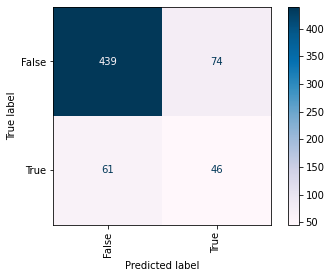

In [24]:
plot_confusionmatrix(df_test["gold"],df_test["y"] )

### Predict Test on Test GT fit

In [25]:
df_test = load_file(local_test_prediction_file)


result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)



print_report_all_classifiers(df_test["gold"], result_test_gt)



/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5992


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      88.8 &   83.8 &     86.3 &     513 \\
Naive Bayes &         True &      39.0 &   49.5 &     43.6 &     107 \\
Naive Bayes &     accuracy &      77.9 &   77.9 &     77.9 &       0 \\
Naive Bayes &    macro avg &      63.9 &   66.7 &     64.9 &     620 \\
Naive Bayes & weighted avg &      80.2 &   77.9 &     78.9 &     620 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.888430,0.838207,0.862588,513.000000
True,Naive Bayes,True,0.389706,0.495327,0.436214,107.000000
accuracy,Naive Bayes,accuracy,0.779032,0.779032,0.779032,0.779032
macro avg,Naive Bayes,macro avg,0.639068,0.666767,0.649401,620.000000
weighted avg,Naive Bayes,weighted avg,0.802360,0.779032,0.789004,620.000000


In [26]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt)





\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      88.5 &   85.4 &     86.9 &     513 \\
Naive Bayes &         True &      40.0 &   46.7 &     43.1 &     107 \\
Naive Bayes &     accuracy &      78.7 &   78.7 &     78.7 &       0 \\
Naive Bayes &    macro avg &      64.2 &   66.1 &     65.0 &     620 \\
Naive Bayes & weighted avg &      80.1 &   78.7 &     79.3 &     620 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.884848,0.853801,0.869048,513.000000
True,Naive Bayes,True,0.400000,0.467290,0.431034,107.000000
accuracy,Naive Bayes,accuracy,0.787097,0.787097,0.787097,0.787097
macro avg,Naive Bayes,macro avg,0.642424,0.660545,0.650041,620.000000
weighted avg,Naive Bayes,weighted avg,0.801173,0.787097,0.793455,620.000000


In [27]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt)



\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      88.3 &   87.4 &     87.8 &     500 \\
Naive Bayes &         True &      49.6 &   51.7 &     50.6 &     120 \\
Naive Bayes &     accuracy &      80.5 &   80.5 &     80.5 &       0 \\
Naive Bayes &    macro avg &      68.9 &   69.5 &     69.2 &     620 \\
Naive Bayes & weighted avg &      80.8 &   80.5 &     80.6 &     620 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.882828,0.874000,0.878392,500.000000
True,Naive Bayes,True,0.496000,0.516667,0.506122,120.000000
accuracy,Naive Bayes,accuracy,0.804839,0.804839,0.804839,0.804839
macro avg,Naive Bayes,macro avg,0.689414,0.695333,0.692257,620.000000
weighted avg,Naive Bayes,weighted avg,0.807958,0.804839,0.806340,620.000000


### Predict Test on Test Prediction fit 

In [28]:
df_test_prediction = load_file(local_test_prediction_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

#plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])


print_report_all_classifiers(df_test_prediction["y"], result_test_bp)





/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5992


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      99.8 &   96.6 &     98.2 &     500 \\
Naive Bayes &         True &      87.5 &   99.2 &     93.0 &     120 \\
Naive Bayes &     accuracy &      97.1 &   97.1 &     97.1 &       0 \\
Naive Bayes &    macro avg &      93.6 &   97.9 &     95.6 &     620 \\
Naive Bayes & weighted avg &      97.4 &   97.1 &     97.2 &     620 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.997934,0.966000,0.981707,500.000000
True,Naive Bayes,True,0.875000,0.991667,0.929688,120.000000
accuracy,Naive Bayes,accuracy,0.970968,0.970968,0.970968,0.970968
macro avg,Naive Bayes,macro avg,0.936467,0.978833,0.955697,620.000000
weighted avg,Naive Bayes,weighted avg,0.974140,0.970968,0.971639,620.000000


In [29]:
p1 = get_top_discrimintary_keywords(result_test_bp[NAIVE_BAYES]["m"],0)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

kl_divergence(p1,p2)

0.04621893231790726

## Test BP 

In [30]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, train_result)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)





\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      88.3 &   87.4 &     87.8 &     500 \\
Naive Bayes &         True &      49.6 &   51.7 &     50.6 &     120 \\
Naive Bayes &     accuracy &      80.5 &   80.5 &     80.5 &       0 \\
Naive Bayes &    macro avg &      68.9 &   69.5 &     69.2 &     620 \\
Naive Bayes & weighted avg &      80.8 &   80.5 &     80.6 &     620 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.882828,0.874000,0.878392,500.000000
True,Naive Bayes,True,0.496000,0.516667,0.506122,120.000000
accuracy,Naive Bayes,accuracy,0.804839,0.804839,0.804839,0.804839
macro avg,Naive Bayes,macro avg,0.689414,0.695333,0.692257,620.000000
weighted avg,Naive Bayes,weighted avg,0.807958,0.804839,0.806340,620.000000


## Large scale high quality

In [31]:
df_highquality = load_file(local_highquality_file)

In [32]:
result_highquality_bp = train_and_predict_all_classifiers(df_highquality, min_df=1)
print_report_all_classifiers(df_highquality["y"], result_highquality_bp)


df_highquality["nb_predictions"]=result_highquality_bp[NAIVE_BAYES]["predictions"]

/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5864


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      90.4 &   86.0 &     88.2 &   97081 \\
Naive Bayes &         True &      85.8 &   90.3 &     88.0 &   91053 \\
Naive Bayes &     accuracy &      88.1 &   88.1 &     88.1 &       0 \\
Naive Bayes &    macro avg &      88.1 &   88.1 &     88.1 &  188134 \\
Naive Bayes & weighted avg &      88.2 &   88.1 &     88.1 &  188134 \\
\bottomrule
\end{tabular}



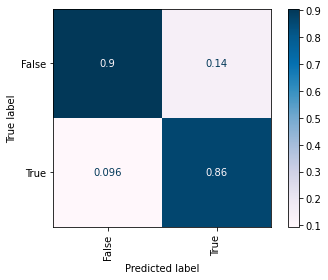

In [33]:
plot_confusionmatrix(df_highquality["y"],df_highquality["nb_predictions"], "pred")

In [34]:
df_highquality.columns

Index(['abstract_id', 'abstract', 'false', 'true', 'prediction', 'confidence',
       'confidence_std', 'raw_confidence', 'RecordInTrainingData',
       'self_label', 'x', 'gold', 'gold_raw', 'y', 'y_raw', 'nb_predictions'],
      dtype='object')

In [35]:
df_highquality.y_raw.value_counts()

False    97081
True     91053
Name: y_raw, dtype: int64

In [36]:
p1 = get_top_discrimintary_keywords(result_highquality_bp[NAIVE_BAYES]["m"], 1)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

kl_divergence(p1,p2)

0.16830998812218764

In [37]:
result_highquality_train_result =  predict_all_classifiers(df_highquality, train_result)
print_report_all_classifiers(df_highquality["y"], result_highquality_train_result)


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      79.4 &   77.7 &     78.6 &   97081 \\
Naive Bayes &         True &      76.8 &   78.5 &     77.6 &   91053 \\
Naive Bayes &     accuracy &      78.1 &   78.1 &     78.1 &       0 \\
Naive Bayes &    macro avg &      78.1 &   78.1 &     78.1 &  188134 \\
Naive Bayes & weighted avg &      78.1 &   78.1 &     78.1 &  188134 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.794286,0.777268,0.785685,97081.000000
True,Naive Bayes,True,0.767827,0.785367,0.776498,91053.000000
accuracy,Naive Bayes,accuracy,0.781188,0.781188,0.781188,0.781188
macro avg,Naive Bayes,macro avg,0.781057,0.781318,0.781091,188134.000000
weighted avg,Naive Bayes,weighted avg,0.781480,0.781188,0.781239,188134.000000


## Low quality

In [38]:
df_lowquality = load_file(local_lowquality_file)


In [39]:

result_lowquality_bp = train_and_predict_all_classifiers(df_lowquality, min_df=1)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_bp)

/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  5156


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      58.5 &   51.4 &     54.7 &   31142 \\
Naive Bayes &         True &      53.7 &   60.7 &     56.9 &   28902 \\
Naive Bayes &     accuracy &      55.8 &   55.8 &     55.8 &       0 \\
Naive Bayes &    macro avg &      56.1 &   56.0 &     55.8 &   60044 \\
Naive Bayes & weighted avg &      56.1 &   55.8 &     55.8 &   60044 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.584582,0.513551,0.546769,31142.000000
True,Naive Bayes,True,0.536529,0.606775,0.569494,28902.000000
accuracy,Naive Bayes,accuracy,0.558424,0.558424,0.558424,0.558424
macro avg,Naive Bayes,macro avg,0.560556,0.560163,0.558132,60044.000000
weighted avg,Naive Bayes,weighted avg,0.561452,0.558424,0.557708,60044.000000


In [40]:
p1 = get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],0)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

kl_divergence(p1,p2)

0.14503638911521888

In [41]:
result_lowquality_train_result =  predict_all_classifiers(df_lowquality, train_result)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_train_result)



\begin{tabular}{llrrrr}
\toprule
      model &        index & precision & recall & f1-score & support \\
\midrule
Naive Bayes &        False &      53.4 &   49.2 &     51.2 &   31142 \\
Naive Bayes &         True &      49.6 &   53.8 &     51.6 &   28902 \\
Naive Bayes &     accuracy &      51.4 &   51.4 &     51.4 &       0 \\
Naive Bayes &    macro avg &      51.5 &   51.5 &     51.4 &   60044 \\
Naive Bayes & weighted avg &      51.6 &   51.4 &     51.4 &   60044 \\
\bottomrule
\end{tabular}



,model,index,precision,recall,f1-score,support
False,Naive Bayes,False,0.534400,0.492101,0.512379,31142.000000
True,Naive Bayes,True,0.495744,0.538025,0.516020,28902.000000
accuracy,Naive Bayes,accuracy,0.514206,0.514206,0.514206,0.514206
macro avg,Naive Bayes,macro avg,0.515072,0.515063,0.514199,60044.000000
weighted avg,Naive Bayes,weighted avg,0.515793,0.514206,0.514132,60044.000000


In [42]:
get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],1)[:20]

[('the', -3.4646863179073772),
 ('.', -3.4984705306015673),
 (',', -3.508342968697077),
 ('of', -3.53893849020608),
 ('-', -3.7451372166868815),
 ('and', -3.7837327900461357),
 ('in', -3.9466450468512964),
 (')', -4.307054870869884),
 ('(', -4.3115933289938475),
 ('to', -4.414255374491015),
 ('a', -4.4636919965156405),
 ('##s', -4.661327655749547),
 ('that', -4.991497304841966),
 ('is', -5.046741371728929),
 ('with', -5.186031440070474),
 ('for', -5.233798786855274),
 ('by', -5.351427248074097),
 ('The', -5.432198355203644),
 ('p', -5.4432874651400525),
 ('as', -5.526834837679868)]

## Summary of Analysis

Training Naive Bayes


Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


Max words :  2000


Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  2000


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  2000


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


Training Naive Bayes
Max words :  2000


/Users/aparnaelangovan/PycharmProjects/venv/bert-shortcuts/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


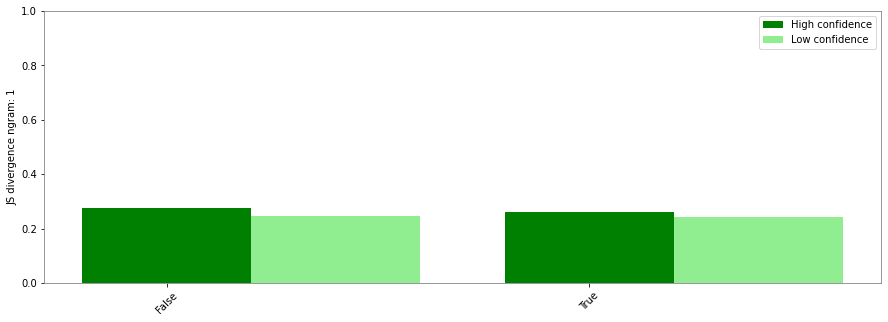

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def compute_js_divergence(p1_model_result, p2_model_result, label_names=label_names, use_common_only=False):
    result = []
    for i, l in enumerate(label_names):
        p = js_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i),
                          use_common_only=use_common_only
                     )
        result.append({
            "label_name" : l,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)
        
def plot_divergence(df1,t1, df2, t2, ax, suffix_y_label):
    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.4
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"], rotation = 45)
    
    ax.set_ylim(0,1)
    
    ax.set_ylabel(f"JS divergence {suffix_y_label}")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')

        

_, axes= plt.subplots(1,1, figsize=(15,5))  

classifiers = {NAIVE_BAYES}

kwargs = {
    "ngram_range":(1,1),
    "min_df": 5,
    "stop_words": None,
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  2000
}

ax = axes
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality.sample(n=50000, random_state=42), 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality.sample(n=50000, random_state=42), 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax,
               "ngram: 1")


# kwargs = {
#     "ngram_range":(2,2),
#     "min_df": 5,
#     "stop_words":None,
#     "classifiers":classifiers,
#     "classwise_vocab":False,
#     "max_words_per_class" :  1000
# }

# ax = axes[1]
# plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                       use_common_only=False
#                                      ),
#                 "High confidence", 
#                 compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ),
#                                        use_common_only=False
#                                      ),
#                 "Low confidence",
#                 ax, "ngram: 2")

# ax.legend().remove()




# kwargs = {
#     "ngram_range":(3,3),
#    "min_df": 5,
#    "stop_words":None,
#     "classifiers":classifiers,
#     "max_words_per_class" :  100,
#     "classwise_vocab":False
# }

# ax = axes[2]
# plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=False
#                                      ),
#                 "High confidence", 
#                 compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=False
#                                      ),
#                 "Low confidence",
#                 ax, "ngram: 3")

# ax.legend().remove()




In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import warnings

def classwise_jacq(df1, df2, label_names=label_names,
                   stop_words=None, 
                   max_words_per_class=3000,
                   min_df=5,
                  ngram_range=(1,1)):
    result = []
    for i,l in enumerate(label_names):
        df1_sub = df1.query(f"y=={i}")
        df2_sub = df2.query(f"y=={i}")
        
        

        cv = CountVectorizer(stop_words=stop_words, max_features=max_words_per_class, min_df=min_df,
                             ngram_range=ngram_range,lowercase=False,
                             analyzer=hf_analyser() )
        
        try:
        
            v1 = cv.fit(df1_sub["x"]).vocabulary_
            v2 = cv.fit(df2_sub["x"]).vocabulary_


            score = jaccard(v1,v2)

            result.append({

                "score" : score,
                "v1" : v1,
                "v2": v2,
                "union": set(v1).union(set(v2)),
                "intersection": set(v1).intersection(set(v2)),
                "onlyv2": set(v2)-set(v1),
                "onlyv1": set(v1)-set(v2)


            })
        except ValueError as e:
            warnings.warn(l + " - "+ str(e))
    return result
kwargs = {
    "ngram_range":(1,1),
    "min_df": 1,
    "stop_words":None,   
    "max_words_per_class" :  None


}




high_jq_result = classwise_jacq(df_highquality, df_train, **kwargs)
              
low_jq_result = classwise_jacq(df_lowquality, df_train, **kwargs)

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


In [49]:
low_jq_result[0]["score"], high_jq_result[0]["score"]

(0.37076072700018736, 0.3308596681397482)

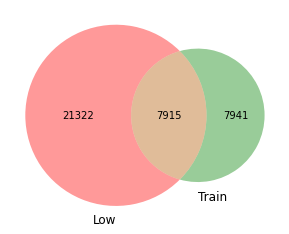

In [50]:
from matplotlib_venn import venn2

def plot_venn( score, set_labels=('Low', 'Train'), label=1):
    venn2(subsets = (len(score[label]["v1"])
                     , len(score[label]["v2"])
                     , len(score[label]["intersection"])
                    ), 
          set_labels = set_labels)
    plt.show()

plot_venn(low_jq_result,label=0)

In [ ]:
print(keywords1)
print([ k for k in keywords1 if k in set(low_jq_result[0]["intersection"])])
print([ k for k in keywords2 if k in set(low_jq_result[0]["intersection"])])

In [ ]:
print(keywords2)
print([ k for k in keywords1 if k in set(low_jq_result[1]["intersection"])])
print([ k for k in keywords2 if k in set(low_jq_result[1]["intersection"])])

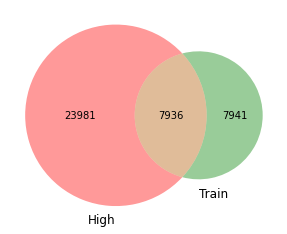

In [51]:
plot_venn(high_jq_result, set_labels=("High", "Train"), label=0)

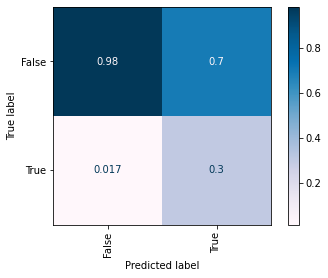

In [52]:
plot_confusionmatrix(df_highquality["gold"],df_highquality["y"], "pred")

In [53]:
df_highquality["confidence"].describe()

count    188134.000000
mean          0.997563
std           0.002152
min           0.990000
25%           0.996799
50%           0.998215
75%           0.999220
max           0.999640
Name: confidence, dtype: float64

In [54]:
df_lowquality["confidence"].describe()

count    60044.000000
mean         0.661945
std          0.087584
min          0.500005
25%          0.587240
50%          0.667730
75%          0.739715
max          0.799999
Name: confidence, dtype: float64

In [55]:
df_test["confidence"].describe()

count    620.000000
mean       0.956045
std        0.099433
min        0.503486
25%        0.975173
50%        0.997518
75%        0.999124
max        0.999631
Name: confidence, dtype: float64

In [56]:
df_train["confidence"].describe()

count    767.000000
mean       0.995575
std        0.010179
min        0.824948
25%        0.996462
50%        0.998371
75%        0.999154
max        0.999617
Name: confidence, dtype: float64

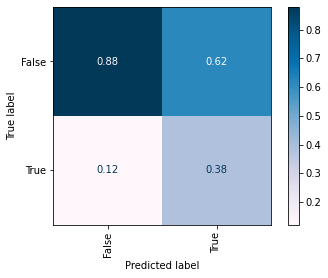

In [57]:
plot_confusionmatrix(df_test["gold"],df_test["y"], "pred")

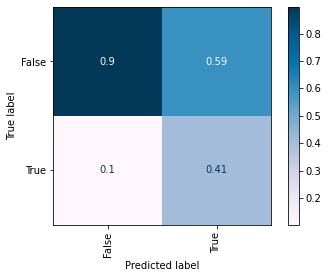

In [58]:
plot_confusionmatrix(df_val["gold"],df_val["y"], "pred")

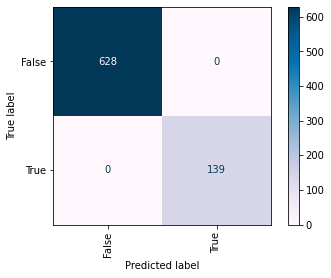

In [59]:
plot_confusionmatrix(df_train["gold"],df_train["y"])

In [ ]:
plot_confusionmatrix(df_highquality["gold"],df_highquality["y"])

In [ ]:
plot_confusionmatrix(df_lowquality["gold"],df_lowquality["y"], "pred")

In [ ]:
plot_confusionmatrix(df_lowquality["gold"],df_lowquality["y"])

## Latex results

In [ ]:
def prepare_latex(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
        
    df_summ = pd.concat(result)
    df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)

df_summ_test_high_conf = print_report_all_classifiers(df_highquality["y"], result_highquality_train_result, all_labels)


df_summ = prepare_latex ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "SELF TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "SELF TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "SELF TS"}, { "name": "T" , "value": "BP"}]},
    {"df": df_summ_test_high_conf, "meta":[{ "name": "dataset" , "value": "SELF GH"}, { "name": "T" , "value": "BP"}]},



                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
               



                ],
    index_filter=[0]
              )

print("**0***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
             




                ],
    index_filter=[2]
              )

print("**2***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
print(len(result_test_bp[NAIVE_BAYES]["m"].vocab))

In [ ]:
def prepare_latex_2(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)



df_summ = prepare_latex_2 ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))